<a href="https://colab.research.google.com/github/sadhami0519/CODING-SAMURAI-INTERNSHIP-TASK/blob/main/predict_house_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [40]:
try:
    from sklearn.datasets import load_boston
    boston = load_boston()
    X = pd.DataFrame(boston.data, columns=boston.feature_names)
    y = pd.Series(boston.target, name='MEDV')
    print("✓ Dataset loaded successfully using sklearn")
except:
    url = "https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv"
    data = pd.read_csv(url)
    X = data.drop('medv', axis=1)
    y = data['medv']
    print("✓ Dataset loaded from external source")

print(f"Dataset shape: {X.shape}")
print(f"Features: {list(X.columns)}")

✓ Dataset loaded from external source
Dataset shape: (506, 13)
Features: ['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'b', 'lstat']


In [41]:
print(f"Missing values: {X.isnull().sum().sum()}")
print(f"Target mean: {y.mean():.2f}, Std: {y.std():.2f}")
print(f"Range: {y.min()} - {y.max()}")

# Correlations with target
correlations = X.corrwith(y).sort_values(key=abs, ascending=False)
print("\nTop correlations with price:")
print(correlations.head(5))

Missing values: 0
Target mean: 22.53, Std: 9.20
Range: 5.0 - 50.0

Top correlations with price:
lstat     -0.737663
rm         0.695360
ptratio   -0.507787
indus     -0.483725
tax       -0.468536
dtype: float64


In [42]:
X_engineered = X.copy()
X_engineered['rm_lstat'] = X['rm'] * X['lstat']
X_engineered['rm_squared'] = X['rm'] ** 2
X_engineered['lstat_squared'] = X['lstat'] ** 2
X_engineered['age_dis'] = X['age'] * X['dis']
X_engineered['crime_nox'] = X['crim'] * X['nox']
X_engineered['log_crim'] = np.log1p(X['crim'])
X_engineered['log_dis'] = np.log1p(X['dis'])
X_engineered['log_lstat'] = np.log1p(X['lstat'])
print(f"Engineered features: {X_engineered.shape[1]}")

Engineered features: 21


In [43]:
X_engineered = X.copy()

# Interaction terms for highly correlated features
X_engineered['rm_lstat'] = X['rm'] * X['lstat']  # Room-wealth interaction
X_engineered['rm_squared'] = X['rm'] ** 2  # Non-linear room effect
X_engineered['lstat_squared'] = X['lstat'] ** 2  # Non-linear wealth effect
X_engineered['age_dis'] = X['age'] * X['dis']  # Age-distance interaction
X_engineered['crime_nox'] = X['crim'] * X['nox']  # Crime-pollution interaction

# Binning continuous variables
X_engineered['rm_category'] = pd.cut(X['rm'], bins=3, labels=['Small', 'Medium', 'Large'])
X_engineered['rm_small'] = (X_engineered['rm_category'] == 'Small').astype(int)
X_engineered['rm_large'] = (X_engineered['rm_category'] == 'Large').astype(int)

# Log transformations for skewed features
X_engineered['log_crim'] = np.log1p(X['crim'])
X_engineered['log_dis'] = np.log1p(X['dis'])
X_engineered['log_lstat'] = np.log1p(X['lstat'])

# Remove categorical column
X_engineered = X_engineered.drop('rm_category', axis=1)

print(f"Original features: {X.shape[1]}")
print(f"Engineered features: {X_engineered.shape[1]}")
print(f"New features: {list(X_engineered.columns[13:])}")

Original features: 13
Engineered features: 23
New features: ['rm_lstat', 'rm_squared', 'lstat_squared', 'age_dis', 'crime_nox', 'rm_small', 'rm_large', 'log_crim', 'log_dis', 'log_lstat']


In [44]:
X_train, X_test, y_train, y_test = train_test_split(
    X_engineered, y, test_size=0.2, random_state=42
)
print(f"Training: {X_train.shape[0]} samples")
print(f"Testing: {X_test.shape[0]} samples")

Training: 404 samples
Testing: 102 samples


In [45]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

selector = SelectKBest(score_func=f_regression, k=15)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

selected_features = X_train.columns[selector.get_support()]
print(f"Selected features: {list(selected_features)}")

Selected features: ['crim', 'indus', 'nox', 'rm', 'rad', 'tax', 'ptratio', 'lstat', 'rm_lstat', 'rm_squared', 'lstat_squared', 'crime_nox', 'rm_large', 'log_crim', 'log_lstat']


In [49]:
# Cell 7 - Model Training & Evaluation
model = LinearRegression()
model.fit(X_train_selected, y_train)

y_pred = model.predict(X_test_selected)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("\nLinear Regression Results:")
print(f"  R²: {r2:.4f}")
print(f"  Accuracy: {r2*100:.2f}%")
print(f"  RMSE: {rmse:.2f}")
print(f"  MAE: {mae:.2f}")


Linear Regression Results:
  R²: 0.8105
  Accuracy: 81.05%
  RMSE: 3.73
  MAE: 2.07


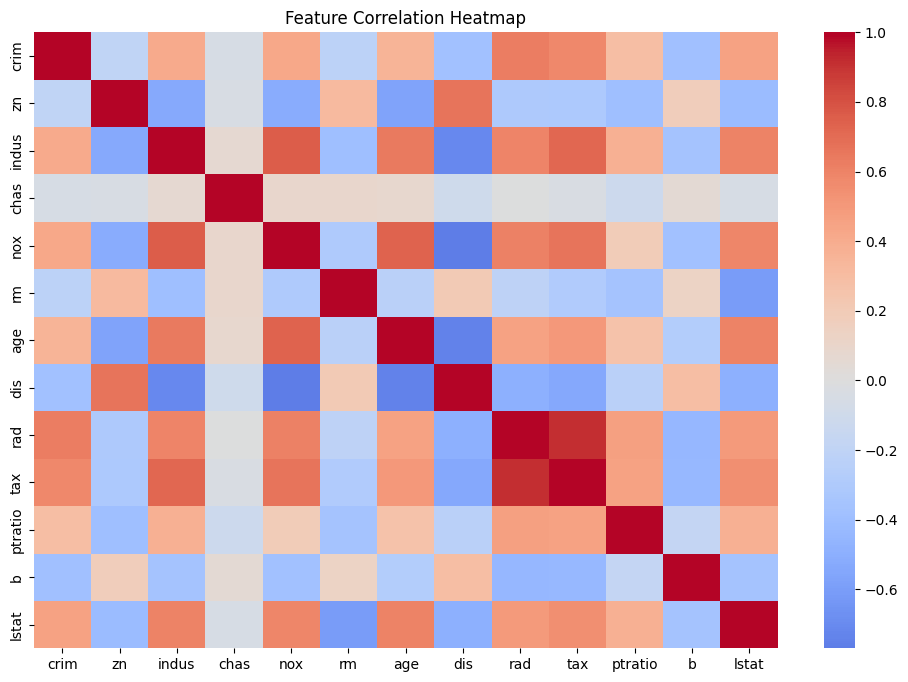

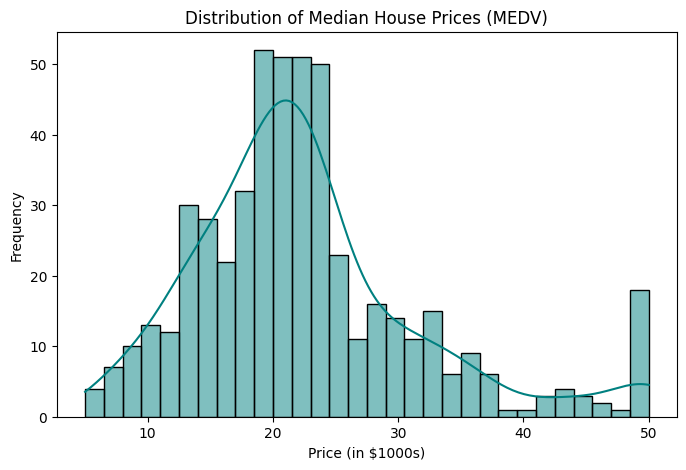

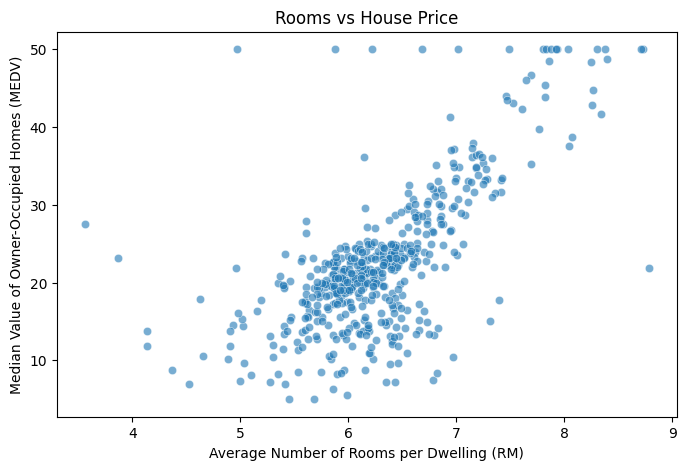

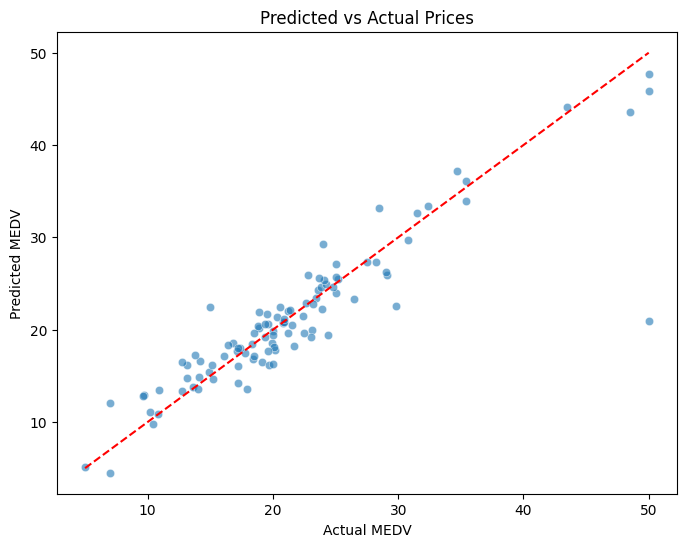

In [48]:
# Cell 8 - Visualizations

# 1. Correlation Heatmap of Features
plt.figure(figsize=(12,8))
sns.heatmap(X.corr(), annot=False, cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

# 2. Distribution of Target Variable (House Prices)
plt.figure(figsize=(8,5))
sns.histplot(y, bins=30, kde=True, color="teal")
plt.title("Distribution of Median House Prices (MEDV)")
plt.xlabel("Price (in $1000s)")
plt.ylabel("Frequency")
plt.show()

# 3. Scatterplot of Key Feature vs Target
plt.figure(figsize=(8,5))
sns.scatterplot(x=X["rm"], y=y, alpha=0.6)
plt.title("Rooms vs House Price")
plt.xlabel("Average Number of Rooms per Dwelling (RM)")
plt.ylabel("Median Value of Owner-Occupied Homes (MEDV)")
plt.show()

# 4. Predicted vs Actual Values
y_pred_final = model.predict(X_test_selected)

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred_final, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color="red", linestyle="--")
plt.title("Predicted vs Actual Prices")
plt.xlabel("Actual MEDV")
plt.ylabel("Predicted MEDV")
plt.show()
